In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.client import device_lib
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, metrics
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPooling2D 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/589_miniproject/

Mounted at /content/drive
/content/drive/MyDrive/589_miniproject


In [5]:
# Get the training data
train_data = pd.read_csv('train.csv', encoding='utf-8')
train_data = train_data.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)
test_data = pd.read_csv('test.csv', encoding='utf-8')
test_data = test_data.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

# adding the file extension
def train_extension(x):
    return 'train/' + x + ".jpg"
def test_extension(x):
    return 'test/' + x + ".jpg"
train_data["img_path"] = train_data["Id"].apply(train_extension)
test_data["img_path"] = test_data["Id"].apply(test_extension)

In [6]:
train_data, test_from_train = train_test_split(train_data, random_state=1, test_size=0.1)
train_data['two_bin'] = pd.qcut(train_data['Pawpularity'], q=2, labels=False)
train_data = train_data.astype({'two_bin': str})

train_data['six_bin'] = pd.qcut(train_data['Pawpularity'], q=6, labels=False)
train_data = train_data.astype({'six_bin': str})

train_data['ten_bin'] = pd.qcut(train_data['Pawpularity'], q=10, labels=False)
train_data = train_data.astype({'ten_bin': str})

twobin_train = train_data.groupby('two_bin')
sixbin_train = train_data.groupby('six_bin')
tenbin_train = train_data.groupby('ten_bin')

# Training Data
train_data.head()

,Id,Pawpularity,img_path,two_bin,six_bin,ten_bin
4277,6d28f8a6941d0f2b5f1999633d44df90,63,train/6d28f8a6941d0f2b5f1999633d44df90.jpg,1,5,8
8552,dd9447d41fe0df9e154b96c2563fd4c4,10,train/dd9447d41fe0df9e154b96c2563fd4c4.jpg,0,0,0
7598,c4088c9c176dc4788aa0c4f084db2505,26,train/c4088c9c176dc4788aa0c4f084db2505.jpg,0,1,2
5614,9088235dd9717c975865f5d03f0cc827,19,train/9088235dd9717c975865f5d03f0cc827.jpg,0,0,1
1117,1ca299575dca8ea695f308ecb87bf710,35,train/1ca299575dca8ea695f308ecb87bf710.jpg,1,3,5


(8920, 6)
838


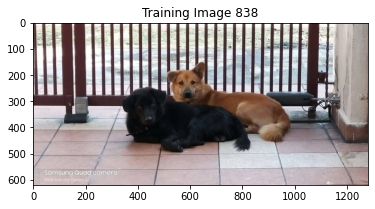

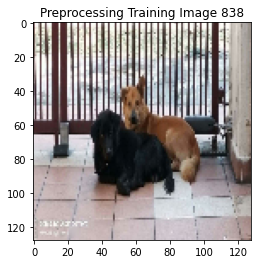

 k-folded Test Data :                                     Id  ...                                    img_path
9111  eb748103742ce414823478dd5e4fe769  ...  train/eb748103742ce414823478dd5e4fe769.jpg
859   15af888f41475f15b01c9fc050e48909  ...  train/15af888f41475f15b01c9fc050e48909.jpg
4453  71c43ce344ddb41341c7f4d1f34dd5b8  ...  train/71c43ce344ddb41341c7f4d1f34dd5b8.jpg
5137  8486e959d13127a6f4c5921d1bf561c8  ...  train/8486e959d13127a6f4c5921d1bf561c8.jpg
8057  d0e0b224e159dc9524eb6c7b945b253d  ...  train/d0e0b224e159dc9524eb6c7b945b253d.jpg

[5 rows x 3 columns]
 Kaggle Test Data :                                  Id                                   img_path
0  4128bae22183829d2b5fea10effdb0c3  test/4128bae22183829d2b5fea10effdb0c3.jpg
1  43a2262d7738e3d420d453815151079e  test/43a2262d7738e3d420d453815151079e.jpg
2  4e429cead1848a298432a0acad014c9d  test/4e429cead1848a298432a0acad014c9d.jpg
3  80bc3ccafcc51b66303c2c263aa38486  test/80bc3ccafcc51b66303c2c263aa38486.jpg
4  8f49844c38

In [7]:
def preprocess_image(image_path):
    raw = tf.io.read_file(image_path)
    return tf.image.resize((tf.cast(tf.image.decode_jpeg(raw, channels=3), tf.float32) / 255.0), (128, 128))

img_num = random.randrange(0, train_data.shape[0]/4)
print(train_data.shape)
print(img_num)
img_rand = plt.imread(train_data['img_path'][img_num]) 
plt.imshow(img_rand)
plt.title(f'Training Image {img_num}')
plt.show()

# Preprocessing images
img0_ts = preprocess_image(train_data['img_path'][img_num])
plt.imshow(img0_ts)
plt.title(f'Preprocessing Training Image {img_num}') 
plt.show()

print(f' k-folded Test Data : {test_from_train.head()}')
print(f' Kaggle Test Data : {test_data.head()}')

In [9]:
prepr_imgs = list()
for img in train_data['img_path']:
    prepr_imgs.append(preprocess_image(img))

prepr_imgs = np.array(prepr_imgs)
    
print(f'Train Data : {prepr_imgs.shape}')

# getting tensors of all images in test folder
imgs_ts = list()
for img in test_from_train['img_path']:
    imgs_ts.append(preprocess_image(img))
imgs_ts = np.array(imgs_ts)
    
print(f'Test Data : {imgs_ts.shape}')

# getting tensors of all images for kaggle test
kaggle_imgs_ts = list()
for img in test_data['img_path']:
    kaggle_imgs_ts.append(preprocess_image(img))
kaggle_imgs_ts = np.array(kaggle_imgs_ts)
    
print(f'Kaggle Test Data : {kaggle_imgs_ts.shape}')

Train Data : (8920, 128, 128, 3)
Test Data : (992, 128, 128, 3)
Kaggle Test Data : (8, 128, 128, 3)


In [10]:
y_test_final=test_from_train['Pawpularity']
x_train, x_test, y_train, y_test= train_test_split(np.array(prepr_imgs), train_data['Pawpularity'], test_size=0.1, random_state=0)
print((np.array(x_train)).shape, (np.array(y_train)).shape, (np.array(x_test)).shape, (np.array(y_test)).shape)

(8028, 128, 128, 3) (8028,) (892, 128, 128, 3) (892,)


In [11]:
inp = tf.keras.Input(shape=(128,128,3))
tf_ts = BatchNormalization()(Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu')(Conv2D(filters = 16, kernel_size = (7,7), kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(inp)))
tf_ts = Dropout(0.5)(BatchNormalization()(Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(tf_ts)))

tf_ts = BatchNormalization()(Conv2D(filters = 64, kernel_size = (3,3), padding='same', activation = 'relu')(tf_ts))
tf_ts = Dropout(0.5)(BatchNormalization()(Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(tf_ts)))

tf_ts = BatchNormalization()(Conv2D(filters = 128, kernel_size = (3,3), padding='same', activation = 'relu')(tf_ts))
tf_ts = MaxPooling2D(pool_size=(2, 2))(tf_ts)
tf_ts = Flatten()(Dropout(0.25)(BatchNormalization()(Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(tf_ts))))

tf_ts = Dropout(0.2)(Dense(512, activation = "relu")(tf_ts))

model = tf.keras.Model(inputs = inp, outputs = layers.Dense(1)(tf_ts))
model.compile(loss = 'mse', optimizer = 'Adam', metrics = [metrics.RootMeanSquaredError(name="rootmse"), "mae", "mape"])

In [ ]:
process = ImageDataGenerator(fill_mode = "nearest")
model_fit = model.fit(process.flow(x_train,y_train,batch_size=32),validation_data = (x_test,y_test),steps_per_epoch = len(x_train)//32,epochs = 100)

Epoch 1/100
250/250 [==============================] - 23s 93ms/step - loss: 489.6920 - rootmse: 22.1232 - mae: 16.6312 - mape: 79.9772 - val_loss: 467.9857 - val_rootmse: 21.6269 - val_mae: 16.8267 - val_mape: 85.9096
Epoch 2/100
250/250 [==============================] - 22s 89ms/step - loss: 465.7616 - rootmse: 21.5754 - mae: 16.1857 - mape: 78.8493 - val_loss: 1273.0580 - val_rootmse: 35.6762 - val_mae: 27.2356 - val_mape: 90.1243
Epoch 3/100
250/250 [==============================] - 22s 88ms/step - loss: 451.5175 - rootmse: 21.2426 - mae: 15.9570 - mape: 78.9902 - val_loss: 591.0297 - val_rootmse: 24.3055 - val_mae: 17.3180 - val_mape: 66.3891
Epoch 4/100
250/250 [==============================] - 22s 88ms/step - loss: 438.5799 - rootmse: 20.9357 - mae: 15.7131 - mape: 77.6416 - val_loss: 981.3500 - val_rootmse: 31.3220 - val_mae: 24.2654 - val_mape: 72.9745
Epoch 5/100
250/250 [==============================] - 22s 88ms/step - loss: 429.7311 - rootmse: 20.7231 - mae: 15.6112 - m

In [ ]:
plt.figure()
plt.plot(model_fit.model_fit["rootmse"], label="train_rmse")
plt.plot(model_fit.model_fit["val_rootmse"], label="val_rmse")
plt.title("RMSE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc="upper left")

In [ ]:
y_pred_test=model.predict(x_test)
print(x_test.shape)
rmse=np.sqrt(mean_squared_error(y_test_final,y_pred_test))
print('RMSE : '+str(rmse))


In [ ]:
# test dataset prediction
pred = model.predict(imgs_ts)
print(imgs_ts.shape, type(imgs_ts), pred.shape, type(pred))
print(np.sqrt(mean_squared_error(y_test_final, pred)))

# kaggle dataset prediction
pred = model.predict(kaggle_imgs_ts)
print(kaggle_imgs_ts.shape, type(kaggle_imgs_ts), pred.shape, type(pred))
print(pred)

# Storing the predictions
mod = pd.DataFrame()
mod['Id'] = test_data['Id']
print(mod.shape)
print(pred)
mod['Pawpularity'] = modpred
mod.to_csv('dl_sol.csv',index=False)